# Gaussian Lowpass Filter

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from util import show_image

In [4]:
img_path = '/Users/jeonhyeonbin/Library/Mobile Documents/com~apple~CloudDocs/POSTECH/계산사진학/assn1/assn2/images/cat.jpg'

In [5]:
img_rgb = cv2.imread(img_path, cv2.IMREAD_COLOR).astype(np.float32)/255.       # RGB
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.    # grayscale

In [6]:
def gaussian_lpf(shape, co):
    P, Q = shape
    u = np.arange(P)
    v = np.arange(Q)
    U, V = np.meshgrid(u, v, indexing='ij')
    
    u_c, v_c = P//2, Q//2
    d_square = (U - u_c)**2 + (V - v_c)**2
    
    g_lpf = np.exp(-d_square / (2 * (co**2)))
    return g_lpf

In [7]:
def gaussian_lpf_gray(img, cutoff, pad_size=10):
    M, N = img.shape
    
    padded_img = cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, borderType=cv2.BORDER_CONSTANT, value=0)

    P, Q = padded_img.shape

    f = np.fft.fft2(padded_img)     # 패딩한 이미지의 푸리에 변환
    f_s = np.fft.fftshift(f)        # 배열 변환
    
    H = gaussian_lpf((P,Q), cutoff)
    filtered_s = f_s * H
    filtered = np.fft.ifftshift(filtered_s) # 배열 원위치
    img_filtered = np.fft.ifft2(filtered)   # 역푸리에 변환
    img_real = np.real(img_filtered)
    out = img_real[pad_size:pad_size+M, pad_size:pad_size+N]
    
    return out        

In [8]:
def gaussian_lpf_gray_show_result(img, cutoff, pad_size=10):
    M, N = img.shape
    
    padded_img = cv2.copyMakeBorder(img, pad_size, pad_size, pad_size, pad_size, borderType=cv2.BORDER_CONSTANT, value=0)

    P, Q = padded_img.shape

    f = np.fft.fft2(padded_img)     # 패딩한 이미지의 푸리에 변환
    f_s = np.fft.fftshift(f)        # 배열 변환
    
    H = gaussian_lpf((P,Q), cutoff)
    filtered_s = f_s * H

    # f_ 시각화
    spectrum = 20 * np.log(np.abs(filtered_s) + 1)  # 로그 스케일로 스펙트럼 계산
    plt.figure(figsize=(5, 5))
    plt.imshow(spectrum, cmap='gray')
    plt.title(f'Spectrum of f_ (cutoff={cutoff})')
    plt.axis('off')
    plt.show()    
    
    
    
    filtered = np.fft.ifftshift(filtered_s) # 배열 원위치
    img_filtered = np.fft.ifft2(filtered)   # 역푸리에 변환
    img_real = np.real(img_filtered)
    out = img_real[pad_size:pad_size+M, pad_size:pad_size+N]
    
    return out        

In [9]:
def gaussian_lpf_rgb(img, cutoff, pad_size=10):
    b, g, r = cv2.split(img) # OpenCV는 bgr순서
    
    b_ = gaussian_lpf_gray(b, cutoff, pad_size=pad_size).astype(np.float32)
    g_ = gaussian_lpf_gray(g, cutoff, pad_size=pad_size).astype(np.float32)
    r_ = gaussian_lpf_gray(r, cutoff, pad_size=pad_size).astype(np.float32)
    
    return cv2.merge([b_, g_, r_])

In [10]:
def gaussian_lpf_rgb_show_result(img, cutoff, pad_size=10):
    b, g, r = cv2.split(img) # OpenCV는 bgr순서
    
    b_ = gaussian_lpf_gray_show_result(b, cutoff, pad_size=pad_size).astype(np.float32)
    g_ = gaussian_lpf_gray_show_result(g, cutoff, pad_size=pad_size).astype(np.float32)
    r_ = gaussian_lpf_gray_show_result(r, cutoff, pad_size=pad_size).astype(np.float32)
    
    return cv2.merge([b_, g_, r_])

In [11]:
def visualize_gaussian_lpf(img_shape, cutoff, pad_size=10):
    """Gaussian Low Pass Filter의 모양을 시각화하는 함수

    Args:
        img_shape (tuple): 원본 이미지의 크기 (height, width)
        cutoff (float): Gaussian 필터의 표준편차 (sigma). 필터의 폭을 조절합니다.
        pad_size (int, optional): 이미지에 추가할 패딩 크기
    """
    # 패딩을 고려한 크기 계산
    M = img_shape[0] + 2 * pad_size
    N = img_shape[1] + 2 * pad_size
    
    # 필터 중심 좌표 계산
    center_x, center_y = M // 2, N // 2
    
    # 좌표 배열 생성 (벡터화)
    x = np.arange(M)
    y = np.arange(N)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 가우시안 필터 마스크 계산
    gaussian_lpf = np.exp(-((X - center_x)**2 + (Y - center_y)**2) / (2 * cutoff**2))
    
    # 필터 모양 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(gaussian_lpf, cmap='gray')
    plt.title(f'Gaussian Low Pass Filter (Sigma = {cutoff})')
    plt.axis('off')  # 축 제거
    plt.show()

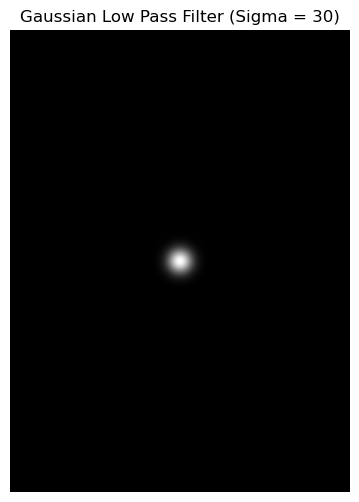

In [12]:
visualize_gaussian_lpf(img_gray.shape, 30, 15)

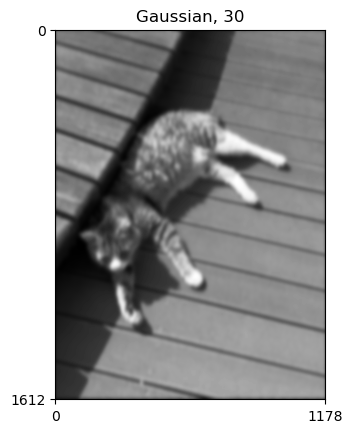

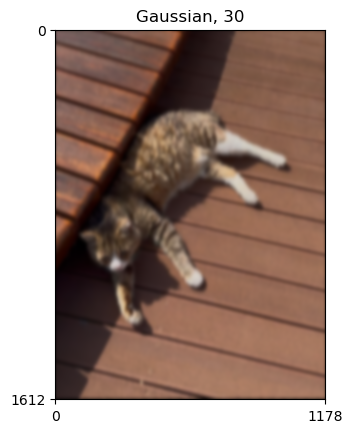

In [13]:
show_image(gaussian_lpf_gray(img_gray, 30, 15), 'Gaussian, 30')
show_image(gaussian_lpf_rgb(img_rgb, 30, 15), 'Gaussian, 30')

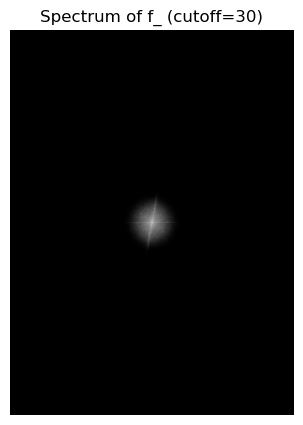

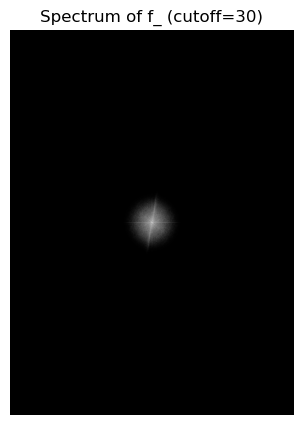

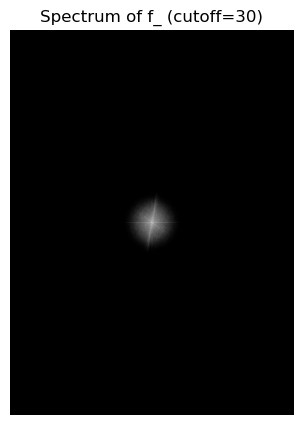

array([[[0.10398886, 0.10641748, 0.13363665],
        [0.11566483, 0.11837862, 0.1486404 ],
        [0.12681617, 0.12980537, 0.1629635 ],
        ...,
        [0.1043333 , 0.12961496, 0.18396266],
        [0.09489231, 0.11789192, 0.16732602],
        [0.08507887, 0.10570503, 0.15002833]],

       [[0.11338989, 0.11604237, 0.14570983],
        [0.12613988, 0.1291055 , 0.1620861 ],
        [0.13832144, 0.14159003, 0.17772318],
        ...,
        [0.11307483, 0.14049166, 0.19931884],
        [0.10283082, 0.12777491, 0.18128255],
        [0.09218707, 0.11455894, 0.16253431]],

       [[0.12266789, 0.12553707, 0.15763405],
        [0.13648169, 0.13969152, 0.17536972],
        [0.14968476, 0.15322478, 0.19230926],
        ...,
        [0.12165993, 0.15117218, 0.21435817],
        [0.11062409, 0.13747655, 0.1949471 ],
        [0.09916268, 0.12324794, 0.17477554]],

       ...,

       [[0.04631959, 0.04604695, 0.06455863],
        [0.05166465, 0.05134635, 0.07202332],
        [0.05681139, 0

In [14]:
gaussian_lpf_rgb_show_result(img_rgb, 30, 15)

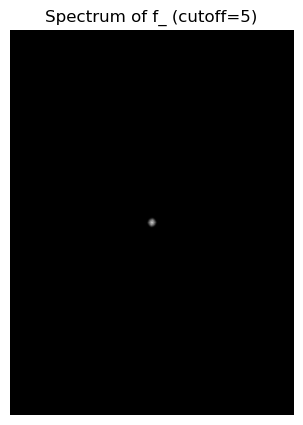

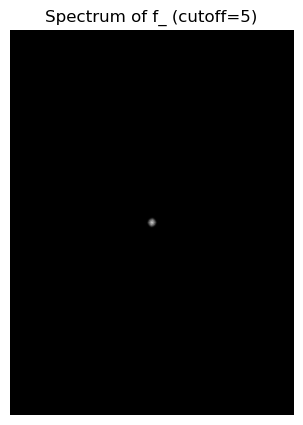

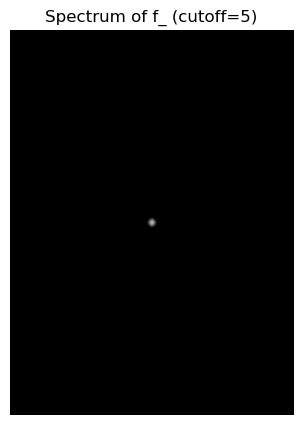

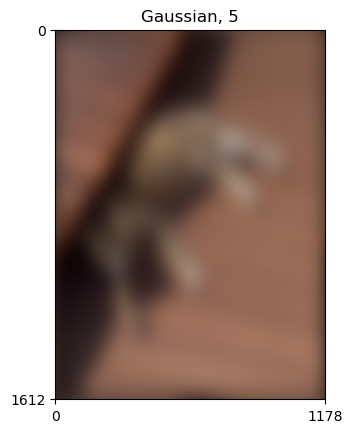

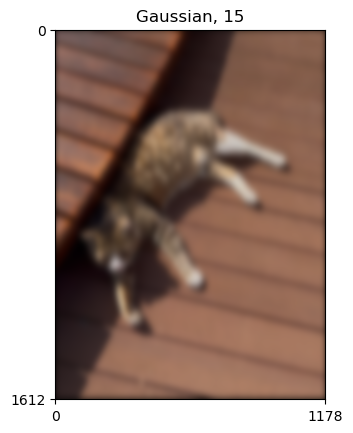

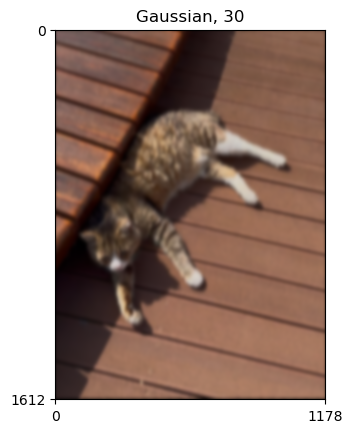

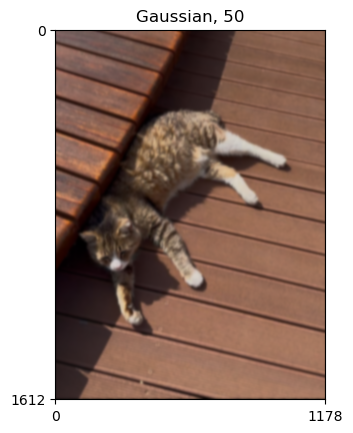

In [18]:
show_image(gaussian_lpf_rgb_show_result(img_rgb, 5, 15), 'Gaussian, 5')
show_image(gaussian_lpf_rgb(img_rgb, 15, 15), 'Gaussian, 15')
show_image(gaussian_lpf_rgb(img_rgb, 30, 15), 'Gaussian, 30')
show_image(gaussian_lpf_rgb(img_rgb, 50, 15), 'Gaussian, 50')